In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from StringIO import StringIO
from pymongo import MongoClient
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(15, 10)

In [2]:
MONGODB_ADDRESS = 'localhost'
MONGODB_PORT = 27017
DB_NAME = 'mass-bank'
COLLECTION_NAME = 'spectrums'

client = MongoClient(host=MONGODB_ADDRESS, port=MONGODB_PORT)

db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# Load and adjust the data

In [3]:
df_train = pd.read_csv('../../data/TableS2_training_hmdb.csv', keep_default_na=False)

df_train = df_train[df_train['Annotation'] == '']
df_train['TYPE'] = 'TRAIN'
df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

df_test = pd.read_csv('../../data/TableS3_training_hmdb.csv', keep_default_na=False)

df_test['TYPE'] = 'TEST'
df_test['RRF_Measured'] = df_test['RRF_Measured'] * 1e-2
df_test['RRF_Predicted'] = df_test['RRF_Predicted'] * 1e-2

In [4]:
# DataFrame(df_train.columns, columns=['Column'])

## Merge Train and Test

In [5]:
df = pd.concat([df_train, df_test])
print("Train + Test Count", len(df))

Train + Test Count 44


# Find all spectrums for the compounds in merged dataset

In [6]:
spectums = []

for index, row_data in df.iterrows():
    currsor = collection.find({'CH$LINK_INCHIKEY': row_data['InChI_Key']})
    
    for item in currsor:
        spectums.append(item)
        
spectrums = DataFrame(spectums)

# Preview
spectrums.head(2)

,AC$INSTRUMENT,AC$INSTRUMENT_TYPE,AC$MASS_SPECTROMETRY_COLLISION_ENERGY,AC$MASS_SPECTROMETRY_ION_MODE,AC$MASS_SPECTROMETRY_MS_TYPE,ACCESSION,AUTHORS,CH$COMPOUND_CLASS,CH$EXACT_MASS,CH$FORMULA,CH$IUPAC,CH$LINK_INCHIKEY,CH$NAME,CH$SMILES,DATE,LICENSE,PK$NUM_PEAK,PK$PEAK,RECORD_TITLE,_id
0,"API3000, Applied Biosystems",LC-ESI-QQ,10 V,POSITIVE,MS2,KO003128,"Kakazu Y, Horai H, Institute for Advanced Bios...",N/A,111.07965,C5H9N3,"InChI=1S/C5H9N3/c6-2-1-5-3-7-4-8-5/h3-4H,1-2,6...",InChIKey=NTYJJOPFIAHURM-UHFFFAOYSA-N,"[Histamine, 2-(4-Imidazolyl)ethylamine, 1H-Imi...",NCCc(c1)ncn1,2011.05.10 (Created 2007.07.07),CC BY-NC-SA,8,m/z int. rel.int.\r\n40.200 34653.5 1\r\n76.00...,Histamine; LC-ESI-QQ; MS2; CE:10 V; [M+H]+,55c0ddfee990fb44f56d6f91
1,"API3000, Applied Biosystems",LC-ESI-QQ,20 V,POSITIVE,MS2,KO003129,"Kakazu Y, Horai H, Institute for Advanced Bios...",N/A,111.07965,C5H9N3,"InChI=1S/C5H9N3/c6-2-1-5-3-7-4-8-5/h3-4H,1-2,6...",InChIKey=NTYJJOPFIAHURM-UHFFFAOYSA-N,"[Histamine, 2-(4-Imidazolyl)ethylamine, 1H-Imi...",NCCc(c1)ncn1,2011.05.10 (Created 2007.07.07),CC BY-NC-SA,11,m/z int. rel.int.\r\n41.300 19802.0 1\r\n67.20...,Histamine; LC-ESI-QQ; MS2; CE:20 V; [M+H]+,55c0ddfee990fb44f56d6f92


## Find suitable spectrum data

In [7]:
group_by = spectrums[['AC$INSTRUMENT', 'AC$MASS_SPECTROMETRY_COLLISION_ENERGY', 'AC$MASS_SPECTROMETRY_ION_MODE', 'CH$LINK_INCHIKEY', '_id']].groupby(['AC$INSTRUMENT', 'AC$MASS_SPECTROMETRY_COLLISION_ENERGY', 'AC$MASS_SPECTROMETRY_ION_MODE'])
unique_spec_count = group_by.agg({'CH$LINK_INCHIKEY': pd.Series.nunique})

unique_spec_count[unique_spec_count['CH$LINK_INCHIKEY'] > 20]

CH$LINK_INCHIKEY
AC$INSTRUMENT               AC$MASS_SPECTROMETRY_COLLISION_ENERGY AC$MASS_SPECTROMETRY_ION_MODE                  
API3000, Applied Biosystems 10 V                                  POSITIVE                                     28
                            20 V                                  POSITIVE                                     28
                            30 V                                  POSITIVE                                     28
                            40 V                                  POSITIVE                                     28
                            50 V                                  POSITIVE                                     28
UPLC Q-Tof Premier, Waters  Ramp 5-60 V                           POSITIVE                                     26

## Filter based on instrument, collision energy and ion mode

In [8]:
INSTRUMENT = 'API3000, Applied Biosystems'
COLLISION_ENERGY = '40 V'
ION_MODE = 'POSITIVE'

condition = (
    (spectrums['AC$INSTRUMENT'] == INSTRUMENT) &
    (spectrums['AC$MASS_SPECTROMETRY_COLLISION_ENERGY'] == COLLISION_ENERGY) &
    (spectrums['AC$MASS_SPECTROMETRY_ION_MODE'] == ION_MODE)
)

filtered = spectrums[condition].copy()
# filtered[]
duplicates = filtered[filtered.duplicated(subset=['CH$LINK_INCHIKEY'])]

# Remove duplicates
if len(duplicates) > 0:
    filtered.drop(duplicates.index, inplace=True)

# filtered[filtered['CH$LINK_INCHIKEY'] == 'InChIKey=VYFYYTLLBUKUHU-UHFFFAOYSA-N']
# filtered.head(2)

## Merge the two datasets (existing train+test and spectrums)

In [9]:
merged = df.merge(filtered, how='inner', left_on='InChI_Key', right_on='CH$LINK_INCHIKEY')

print('Compounds Count', len(merged))
print('Train', len(merged[merged['TYPE'] == 'TRAIN']))
print('Test', len(merged[merged['TYPE'] == 'TEST']))

Compounds Count 28
Train 23
Test 5


### Preview (dataframe)

In [10]:
columns = ['Name', 'Short Name', 'TYPE', 'RRF_Measured', 'RRF_Predicted', 'PK$PEAK']
merged[columns].head()

,Name,Short Name,TYPE,RRF_Measured,RRF_Predicted,PK$PEAK
0,Histamine,HisN,TRAIN,0.00111,0.00615,m/z int. rel.int.\r\n11.100 24752.5 2\r\n39.10...
1,L-Valine,Val,TRAIN,0.00188,0.00263,m/z int. rel.int.\r\n15.500 29703.0 7\r\n39.20...
2,Nicotinamide,NAm,TRAIN,0.00322,0.00755,m/z int. rel.int.\r\n38.400 84158.5 3\r\n44.00...
3,Nicotinic acid,NA,TRAIN,0.00250,0.00543,m/z int. rel.int.\r\n45.100 193069.5 708\r\n78...
4,L-Leucine,Leu,TRAIN,0.01610,0.01250,m/z int. rel.int.\r\n39.100 49505.0 19\r\n41.2...


### Create sparse vectors from the peak data

In [11]:
from scipy import sparse

def peak_to_vec(peak_str):
    df = pd.read_csv(StringIO(peak_str), sep=' ')
    df['m/z'] = df['m/z'].apply(np.round)
    df = df[['m/z', 'int.']].groupby(['m/z']).sum()
    df['rel.int.'] = 999.0 * (df['int.'] / df['int.'].max())
    df['rel.int.'] = df['rel.int.'].apply(round)
    
    vec = {int(k):v['rel.int.'] for (k,v) in df.iterrows()}
    
    return vec

def vec_to_sparse(vec, max_):   
    data = np.array(vec.values())
    indices = np.array(vec.keys())
    indptr = np.array([0] + [len(vec)])
    mtx = sparse.csr_matrix((data, indices, indptr), shape=(1, max_ + 1))
    
    return np.ravel(mtx.todense())

merged['PEAK_VEC'] = merged['PK$PEAK'].apply(peak_to_vec)

max_mz = 0

for i, row in merged.iterrows():
    vec = row['PEAK_VEC']
    max_in = max(vec.iteritems(), key=lambda x: x[0])
    max_mz = max(max_mz, max_in[0])

merged['PEAK_VEC_SPARSE'] = merged['PEAK_VEC'].apply(lambda v: vec_to_sparse(v, max_mz))

### Preview (sparse vector)

In [12]:
merged.iloc[0]['PEAK_VEC_SPARSE']

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,   16.,    0.,  267.,   33.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         98.,   36.,   58.,    0.,    0.,    0.,    0.,    0.,    2.,
          0.,    0.,    0.,    0.,  170.,  999.,   12.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,   23.,    0.,   10.,
        298.,  217.,  171.,    0.,    0.,    2.,    0.,    0.,    0.,
          0.,    0.,    0.,    3.,    0.,  613.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

# Data preparation

In [13]:
# Training Data
X_train = merged['PEAK_VEC_SPARSE']
X_train = X_train[merged['TYPE'] == 'TRAIN']

y_train = merged[['RRF_Measured']]
y_train = y_train[merged['TYPE'] == 'TRAIN']

# Testing Data
X_test = merged['PEAK_VEC_SPARSE']
X_test = X_test[merged['TYPE'] == 'TEST']

y_test = merged[['RRF_Measured']]
y_test = y_test[merged['TYPE'] == 'TEST']

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 23
Number of metabolites (testing): 5


In [14]:
stacked_training = np.vstack((X_train.loc[:]))
stacked_test = np.vstack((X_test.loc[:]))

X_range = np.arange(max_mz + 1)
print("Training - shape", stacked_training.shape)
print("Test - shape", stacked_test.shape)

Training - shape (23, 809)
Test - shape (5, 809)


# Fit Gaussian Process

In [15]:
model = GPy.models.GPRegression(stacked_training, y_train)
model.optimize()

###  What the kernel looks like ???

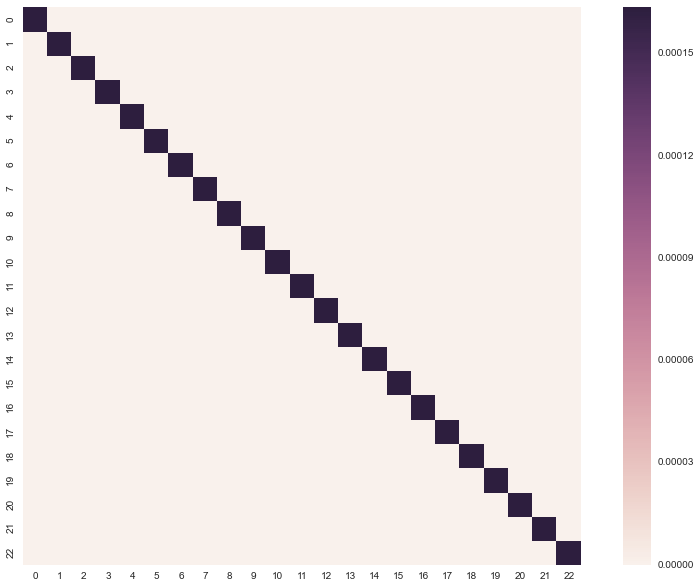

In [16]:
sns.heatmap(model.kern.K(stacked_training), square=True)
plt.show()

### Model stats

In [17]:
from IPython.display import display
display(model)

# Predictions

In [18]:
mu, var = model.predict(stacked_test)

In [19]:
data = pd.concat([merged[merged['TYPE'] == 'TEST'], DataFrame(mu, columns=['Prediction'], index=X_test.index)], axis=1)

data[['Name', 'RRF_Measured', 'Prediction', 'RRF_Predicted']]

,Name,RRF_Measured,Prediction,RRF_Predicted
23,L-Ornithine,0.00281,0,0.00631
24,3-Methyl-L-Histidine,0.01400,0,0.02280
25,L-Citrulline,0.01160,0,0.01600
26,L-Carnosine,0.01910,0,0.03030
27,1-Methyl-Adenosine,0.05240,0,0.05110


# Comparison of model metrics

In [20]:
y_true = data['RRF_Measured']
y_pred = data['RRF_Predicted']
y_pred_new = data['Prediction']

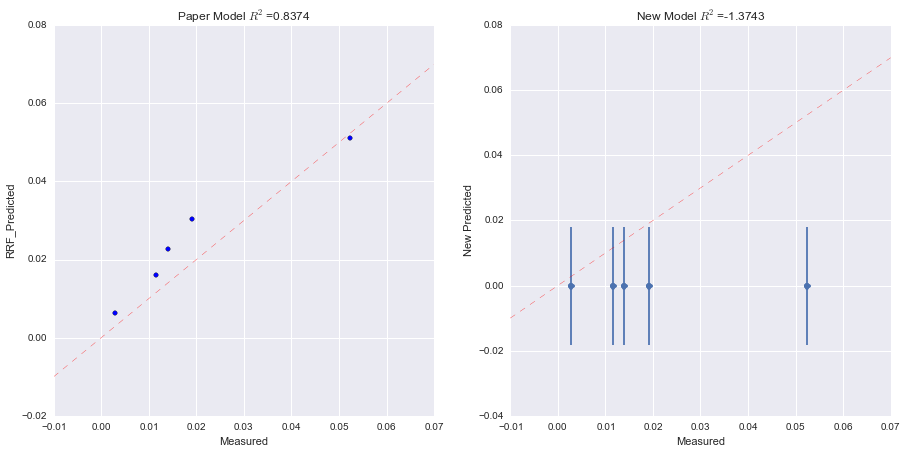

In [21]:
figsize(15, 7)
plt.subplot(1, 2, 1)
plt.xlabel('Measured')
plt.ylabel('RRF_Predicted')
plt.scatter(y_true, y_pred)

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)
plt.title('Paper Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred)))

# ===

plt.subplot(1, 2, 2)
plt.xlabel('Measured')
plt.ylabel('New Predicted')
plt.scatter(y_true, y_pred_new)

# ylim = plt.ylim()
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o')
# plt.ylim(*ylim)

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.show()

## Metrics of the model reported in the paper

In [22]:
print("explained_variance", explained_variance_score(y_true, y_pred))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred))
print("mean_squared_error", mean_squared_error(y_true, y_pred))
print("r2_score", r2_score(y_true, y_pred))

explained_variance 0.934829681515
mean_absolute_error 0.00584
mean_squared_error 4.7236e-05
r2_score 0.837411524278


## Metrics of our model

In [23]:
print("explained_variance", explained_variance_score(y_true, y_pred_new))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred_new))
print("mean_squared_error", mean_squared_error(y_true, y_pred_new))
print("r2_score", r2_score(y_true, y_pred_new))

explained_variance 0.0
mean_absolute_error 0.019982
mean_squared_error 0.00068980522
r2_score -1.3743411649
